## The best neighborhood in Pittsburgh by playground equipment

This is Eric Anderson's solo portion of the final project.

I want to discover which neighborhood in Pittsburgh has the best playgrounds. In order to do so, I will be analyzing [this dataset](https://data.wprdc.org/dataset/playground-equipment) published by the City of Pittsburgh.

In [54]:
#setting up the dataset with pandas and seeing what a sample of it looks like

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

playground_equipment = pd.read_csv("playground_data.csv")
playground_equipment.head()

,id,name,equipment_type,manufacturer,safety_surface_type,ada_accessible,street_number,street,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1780722587,Able Long Playground,Play Area 2 to 5,Little Tykes,Pour in Place,f,211.0,Coast Ave,Beechview,4,19,42003192000,5,19,6,4-28,40.408381,-80.028520
1,702514290,North Ave. Playground,Play Area 2 to 5,Playworld,SofSurfaces,f,377.0,W North Ave,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.454526,-80.010188
2,1267038491,Vietnam Veteran's Playground,Slide,Little Tykes,SofSurfaces,f,108.0,Panther Hollow Rd,Squirrel Hill South,5,14,42003980500,3,14,4,2-8,40.434185,-79.944323
3,14898932,Schenley Overlook Playground,Swing 2 Bays,Little Tykes,SofSurfaces,t,NaN,Overlook Dr,Squirrel Hill South,5,14,42003980500,3,14,4,2-8,40.432130,-79.947774
4,204832406,Schenley Overlook Playground,Slide,Little Tykes,SofSurfaces,f,NaN,Overlook Dr,Squirrel Hill South,5,14,42003980500,3,14,4,2-8,40.432215,-79.947817


In [3]:
#since I want to find the best nieghborhood, I'll group by neighborhood

grouped_equipment = playground_equipment.groupby('neighborhood')

#Now I can start looking at the different statistics for each neighborhood
print("Number of playgrounds:")
print(grouped_equipment.name.nunique())

print("\nNumber of pieces of equipment:")
print(grouped_equipment.id.count())

print("\nNumber of ADA accessible pieces of equipment (true = accessible):")
print(grouped_equipment.ada_accessible.value_counts())

print("\nNumber of unique pieces of equipment:")
print(grouped_equipment.equipment_type.nunique())


Number of playgrounds:
neighborhood
Allegheny Center       3
Allentown              1
Banksville             1
Bedford Dwellings      1
Beechview              5
                      ..
Upper Lawrenceville    3
West End               1
West Oakland           1
Westwood               1
Windgap                1
Name: name, Length: 66, dtype: int64

Number of pieces of equipment:
neighborhood
Allegheny Center       15
Allentown               4
Banksville              6
Bedford Dwellings       3
Beechview              21
                       ..
Upper Lawrenceville     5
West End                3
West Oakland            1
Westwood                2
Windgap                 5
Name: id, Length: 66, dtype: int64

Number of ADA accessible pieces of equipment (true = accessible):
neighborhood      ada_accessible
Allegheny Center  f                 14
                  t                  1
Allentown         f                  3
                  t                  1
Banksville        f           

## How to rank the neighborhoods

I want to give each neighborhood a score between 0 and 1 so that it is easy to combine my rankings with those of my group into one final score. To do this, I will assign different features of the neighborhoods' playgrounds values and sum them. Then, I will normalize the scores to be between 0 and 1.

An initial question is whether to adjust the number of playgrounds and amount of equipment for the size of the neighborhood. My answer to this is yes and no. I want neighborhoods to get points for having few playgrounds of higher quality, as well as having many playgrounds of lesser quality. My reasoning here is that both are important. Having good playgrounds and also variety and choice is important. In my personal experience as a child in a small neighborhood we had to drive to the nearest playground anyways, so even if a bigger neighborhood means that you are farther from a playground I don't think it should be counted against the neighborhood. In other words, the more playgrounds, the better.

I think I will add up 2 scores to get my final standings. First, the 'quality' metric. For this, I will sum the number of ADA accessible equipment pieces and the number of unique equipment pieces and divide that total by the number of playgrounds. This will give an average quality value for a neighborhood's playgrounds. Then, I will create a 'quantity' metric. This will measure the shear amount of playgrounds and equipment. For this, I will sum the number of playgrounds and the number of equipment pieces in each neighborhood. The number of playgrounds will be multiplied by a constant value to give them more weight compared with the number of equipment pieces. Both metrics, 'quality' and 'quantity', will be added to get the total score for a neighborhood. Because the quality is an average and will be smaller than the quantity metric, I will adjust it by multiplying it by a constant that reflects how important I feel quality is compared to quantity.

In [106]:
# creating the dictionary with every neighborhood in the dataset and assigning it a score of 0 to start
playground_scores = dict()
for neighborhood in playground_equipment.neighborhood.unique():
    playground_scores[neighborhood] = 0

# setting up the constants
num_playgrounds_weight = 2  
ada_accessible_weight = 4
quality_weight = 10

# adding the score for number of unique equipment pieces (quality)
for i in range(grouped_equipment.equipment_type.nunique().count()):
    playground_scores[grouped_equipment.equipment_type.nunique().index[i]] += grouped_equipment.equipment_type.nunique()[i] / grouped_equipment.id.count()[i]

# adding the score for the number of ADA accessible equipment pieces
for i in range(grouped_equipment.ada_accessible.value_counts().count()):
    if grouped_equipment.ada_accessible.value_counts().index[i][1] == "t":
        playground_scores[grouped_equipment.ada_accessible.value_counts().index[i][0]] += grouped_equipment.ada_accessible.value_counts()[i] * ada_accessible_weight

# weight the quality score
for neighborhood in playground_scores:
    playground_scores[neighborhood] *= quality_weight
        
# adding the score for number of pieces of equipment (quantity)
for i in range(grouped_equipment.id.count().count()):
    playground_scores[grouped_equipment.id.count().index[i]] += grouped_equipment.id.count()[i]

# adding the score for number of playgrounds (quantity)
for i in range(grouped_equipment.name.nunique().count()):
    playground_scores[grouped_equipment.name.nunique().index[i]] += grouped_equipment.name.nunique()[i] * num_playgrounds_weight

# normalizing the score to a (0, 1) range
max_score = max(playground_scores.values())
for neighborhood in playground_scores:
    playground_scores[neighborhood] /= max_score
    playground_scores[neighborhood] = round(playground_scores[neighborhood], 3)
    
# sort the scores so we can see what neighborhood won
sorted_scores = sorted(playground_scores.items(), key=lambda x: x[1], reverse=True)
print(sorted_scores)

[('Squirrel Hill South', 1.0), ('Beechview', 0.59), ('South Side Slopes', 0.564), ('Elliott', 0.549), ('Sheraden', 0.436), ('Highland Park', 0.43), ('Mount Washington', 0.424), ('Beltzhoover', 0.319), ('Hazelwood', 0.314), ('Bloomfield', 0.3), ('Carrick', 0.3), ('Crawford-Roberts', 0.297), ('Brighton Heights', 0.296), ('Lincoln-Lemington-Belmar', 0.296), ('Greenfield', 0.295), ('East Liberty', 0.292), ('Morningside', 0.292), ('Manchester', 0.291), ('Fineview', 0.29), ('South Side Flats', 0.286), ('Allegheny Center', 0.206), ('Garfield', 0.186), ('Troy Hill', 0.184), ('Lincoln Place', 0.176), ('Banksville', 0.175), ('Swisshelm Park', 0.175), ('Regent Square', 0.173), ('South Oakland', 0.172), ('Crafton Heights', 0.171), ('Upper Hill', 0.171), ('Marshall-Shadeland', 0.171), ('Upper Lawrenceville', 0.171), ('Terrace Village', 0.168), ('Oakwood', 0.168), ('Allentown', 0.168), ('Polish Hill', 0.168), ('Homewood West', 0.168), ('Duquesne Heights', 0.168), ('Homewood North', 0.168), ('Windgap

## Analyzing the results

Now that I have calculated my scores for each neighborhood, I can visualize the data and see if any changes need to be made to my scoring algorithm.

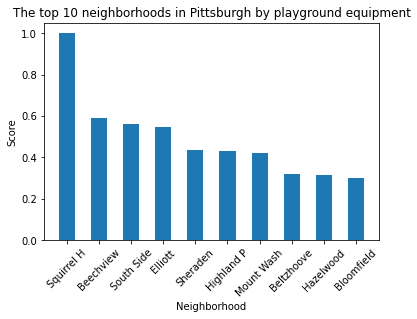

In [107]:
data = []
labels = []
for i in range(10):
    labels.append(sorted_scores[i][0][0:10])
    data.append(sorted_scores[i][1])

plt.bar(labels, data, width=0.5)
plt.title("The top 10 neighborhoods in Pittsburgh by playground equipment")
plt.xlabel("Neighborhood")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

I also wanted to see how well my scoring system treated different sized neighborhoods. Basically, I wanted to how my scores compared to the scores if a there was no adjustment for quality of playgrounds and no weighting. So, I decided to do another score calculation with only the number of equipment pieces.

In [108]:
# creating the dictionary with every neighborhood in the dataset and assigning it a score of 0 to start
unweighted_scores = dict()
for neighborhood in playground_equipment.neighborhood.unique():
    unweighted_scores[neighborhood] = 0

# adding the score for number of pieces of equipment (quantity)
for i in range(grouped_equipment.name.nunique().count()):
    unweighted_scores[grouped_equipment.name.nunique().index[i]] += grouped_equipment.name.nunique()[i]

# normalizing the score to a (0, 1) range
max_score = max(unweighted_scores.values())
for neighborhood in unweighted_scores:
    unweighted_scores[neighborhood] /= max_score
    unweighted_scores[neighborhood] = round(unweighted_scores[neighborhood], 3)
    
# sort the scores so we can see what neighborhood won
sorted_unweighted = sorted(unweighted_scores.items(), key=lambda x: x[1], reverse=True)
print(sorted_unweighted)

[('Squirrel Hill South', 1.0), ('Beechview', 0.625), ('South Side Slopes', 0.625), ('Sheraden', 0.5), ('Highland Park', 0.5), ('Beltzhoover', 0.5), ('Allegheny Center', 0.375), ('Hazelwood', 0.375), ('Mount Washington', 0.375), ('Crawford-Roberts', 0.375), ('Elliott', 0.375), ('Upper Lawrenceville', 0.375), ('South Oakland', 0.375), ('Crafton Heights', 0.25), ('Lincoln Place', 0.25), ('Brookline', 0.25), ('Brighton Heights', 0.25), ('East Liberty', 0.25), ('Central Northside', 0.25), ('Bloomfield', 0.25), ('Lincoln-Lemington-Belmar', 0.25), ('Greenfield', 0.25), ('Marshall-Shadeland', 0.25), ('Morningside', 0.25), ('South Side Flats', 0.25), ('Manchester', 0.25), ('Garfield', 0.25), ('Carrick', 0.25), ('Troy Hill', 0.25), ('Windgap', 0.125), ('Perry South', 0.125), ('Fineview', 0.125), ('Terrace Village', 0.125), ('Oakwood', 0.125), ('New Homestead', 0.125), ('Upper Hill', 0.125), ('Allentown', 0.125), ('Shadyside', 0.125), ('Westwood', 0.125), ('Hays', 0.125), ('Polish Hill', 0.125), 

And now I could compare the two rankings with a bar chart

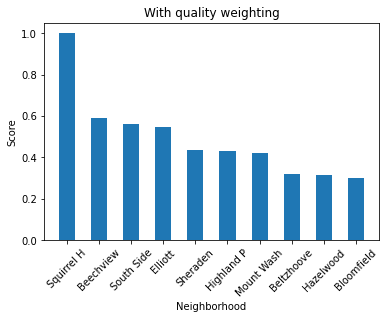

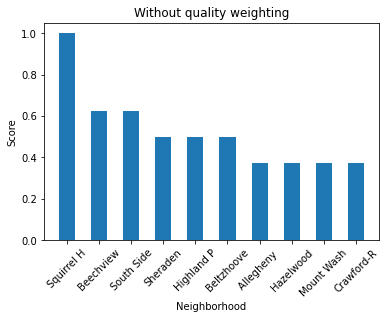

In [109]:
data = []
labels = []
for i in range(10):
    labels.append(sorted_scores[i][0][0:10])
    data.append(sorted_scores[i][1])

plt.bar(labels, data, width=0.5)
plt.title("With quality weighting")
plt.xlabel("Neighborhood")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

data2 = []
labels2 = []
for i in range(10):
    labels2.append(sorted_unweighted[i][0][0:10])
    data2.append(sorted_unweighted[i][1])

plt.bar(labels2, data2, width=0.5)
plt.title("Without quality weighting")
plt.xlabel("Neighborhood")
plt.ylabel("Score")
plt.xticks(rotation=45)

plt.show()

I found that my weighting didn't have a huge impact on the scores, but that's okay because I wanted to factor both quality and quantity into my scoring. With no weighting the top three spots remained the same, but Elliot drops off the top 10 from the number 4 spot, and the bottom half of the list gets rearranged.
# Here is the complete code and visualization I am using to find which Pittsburgh neighborhood has the best playground equipment:

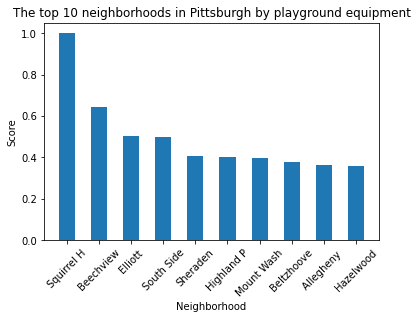

1. Squirrel Hill South - 1.0
2. Beechview - 0.643
3. Elliott - 0.506
4. South Side Slopes - 0.5
5. Sheraden - 0.408
6. Highland Park - 0.402
7. Mount Washington - 0.397
8. Beltzhoover - 0.38
9. Allegheny Center - 0.365
10. Hazelwood - 0.361


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

playground_equipment = pd.read_csv("playground_data.csv")
playground_equipment.head()

grouped_equipment = playground_equipment.groupby('neighborhood')

# creating the dictionary with every neighborhood in the dataset and assigning it a score of 0 to start
playground_scores = dict()
for neighborhood in playground_equipment.neighborhood.unique():
    playground_scores[neighborhood] = 0

# setting up the constants
num_playgrounds_weight = 2  
ada_accessible_weight = 4
quality_weight = 10

# adding the score for number of unique equipment pieces (quality)
for i in range(grouped_equipment.equipment_type.nunique().count()):
    playground_scores[grouped_equipment.equipment_type.nunique().index[i]] += grouped_equipment.equipment_type.nunique()[i]

# adding the score for the number of ADA accessible equipment pieces
for i in range(grouped_equipment.ada_accessible.value_counts().count()):
    if grouped_equipment.ada_accessible.value_counts().index[i][1] == "t":
        playground_scores[grouped_equipment.ada_accessible.value_counts().index[i][0]] += grouped_equipment.ada_accessible.value_counts()[i] * ada_accessible_weight

# weight the quality score
for neighborhood in playground_scores:
    playground_scores[neighborhood] *= quality_weight
        
# adding the score for number of pieces of equipment (quantity)
for i in range(grouped_equipment.id.count().count()):
    playground_scores[grouped_equipment.id.count().index[i]] += grouped_equipment.id.count()[i]

# adding the score for number of playgrounds (quantity)
for i in range(grouped_equipment.name.nunique().count()):
    playground_scores[grouped_equipment.name.nunique().index[i]] += grouped_equipment.name.nunique()[i] * num_playgrounds_weight

# normalizing the score to a (0, 1) range
max_score = max(playground_scores.values())
for neighborhood in playground_scores:
    playground_scores[neighborhood] /= max_score
    playground_scores[neighborhood] = round(playground_scores[neighborhood], 3)
    
# sort the scores so we can see what neighborhood won
sorted_scores = sorted(playground_scores.items(), key=lambda x: x[1], reverse=True)

data = []
labels = []
for i in range(10):
    labels.append(sorted_scores[i][0][0:10])
    data.append(sorted_scores[i][1])

plt.bar(labels, data, width=0.5)
plt.title("The top 10 neighborhoods in Pittsburgh by playground equipment")
plt.xlabel("Neighborhood")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

for i in range(10):
    print(str(i + 1) + ". " + sorted_scores[i][0] + " - " + str(sorted_scores[i][1]))

## Conclusion
Squirrel Hill South is the best neighborhood for playground equipment by a substantial margin. A cursory look at Squirrel Hill Park's Wikipedia page shows that it is the nieghborhood that most of Schenley Park is technically part of, so it makes sense that Squirrel Hill would have a high ranking.